Sử dụng MAPE từ sklearn
Thông tin dữ liệu:
        Date       Price Vol. Change %
0 2020-01-01  -78.709336   1M       0%
1 2020-01-02  160.297364   1M       0%
2 2020-01-03  -90.981308   1M       0%
3 2020-01-04  -35.691099   1M       0%
4 2020-01-05   65.140934   1M       0%
Epoch 10/100, Train Loss: 0.0272, Train MAPE: 1.08%, Val Loss: 0.0387, Val MAPE: 1.00%
Epoch 20/100, Train Loss: 0.0278, Train MAPE: 1.00%, Val Loss: 0.0386, Val MAPE: 1.00%
Epoch 30/100, Train Loss: 0.0282, Train MAPE: 1.01%, Val Loss: 0.0386, Val MAPE: 1.00%
Epoch 40/100, Train Loss: 0.0274, Train MAPE: 1.01%, Val Loss: 0.0386, Val MAPE: 1.00%
Epoch 50/100, Train Loss: 0.0282, Train MAPE: 1.01%, Val Loss: 0.0386, Val MAPE: 1.00%
Epoch 60/100, Train Loss: 0.0282, Train MAPE: 1.00%, Val Loss: 0.0386, Val MAPE: 1.00%
Epoch 70/100, Train Loss: 0.0280, Train MAPE: 1.00%, Val Loss: 0.0386, Val MAPE: 0.99%
Epoch 80/100, Train Loss: 0.0272, Train MAPE: 1.00%, Val Loss: 0.0386, Val MAPE: 1.00%
Epoch 90/100, Train Loss: 0

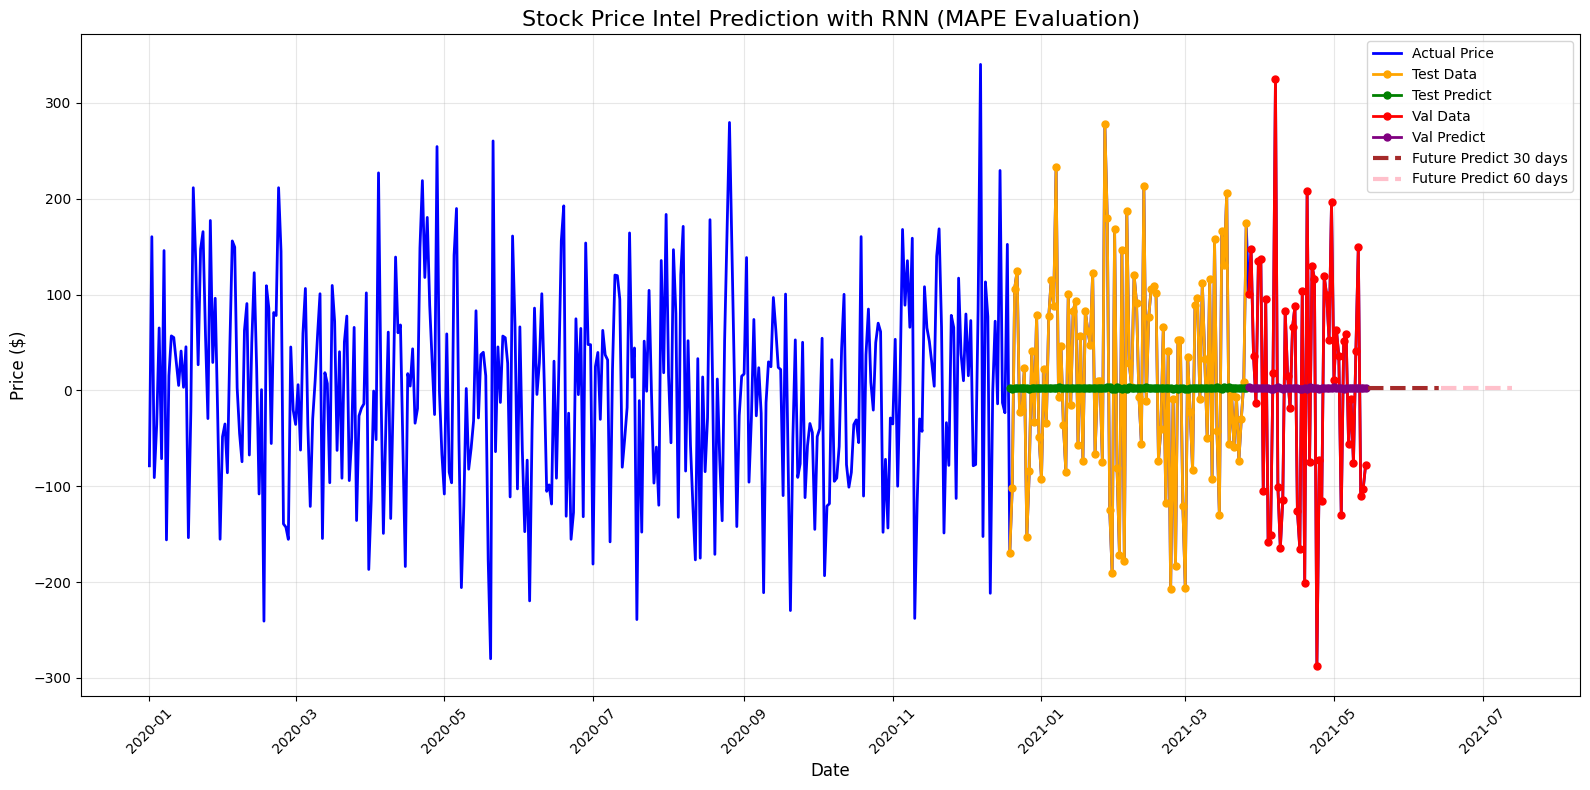

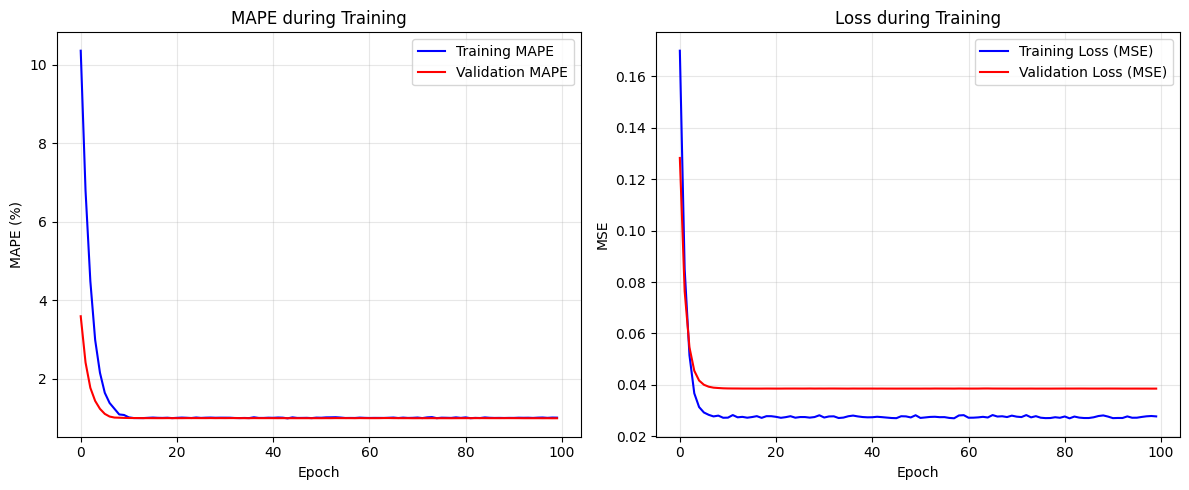


Tóm tắt kết quả đánh giá với MAPE:
Test MAPE: 1.01%
Validation MAPE: 0.99%
MAPE càng thấp thì mô hình dự đoán càng chính xác.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import timedelta

# Thử import MAPE từ sklearn (có từ phiên bản 0.24+)
try:
    from sklearn.metrics import mean_absolute_percentage_error
    print("Sử dụng MAPE từ sklearn")
except ImportError:
    # Nếu không có, tự định nghĩa hàm MAPE
    def mean_absolute_percentage_error(y_true, y_pred):
        """
        Tính Mean Absolute Percentage Error (MAPE)
        """
        # Tránh chia cho 0
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    print("Sử dụng MAPE tự định nghĩa")

df = pd.read_csv('intel_stock_price.csv')

# Chuyển đổi cột Date sang định dạng datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Sắp xếp dữ liệu theo thứ tự tăng dần của ngày
df = df.sort_values('Date')

# Loại bỏ ký tự 'M' và '%' trong các cột và chuyển sang kiểu số
from sklearn.datasets import make_regression
X_fake, y_fake = make_regression(n_samples=500, n_features=1, noise=0.1)
df = pd.DataFrame({'Date': pd.date_range(start='1/1/2020', periods=500), 'Price': y_fake})
df['Vol.'] = '1M'
df['Change %'] = '0%'

# Hiển thị thông tin ban đầu
print("Thông tin dữ liệu:")
print(df.head())

# Chọn cột 'Price' làm đặc trưng để dự đoán
data = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Tiền xử lý dữ liệu và chia tập dữ liệu
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Độ dài chuỗi (số ngày sử dụng để dự đoán)
sequence_length = 10

# Tạo chuỗi dữ liệu
X, y = create_sequences(scaled_data, sequence_length)

# Tính số lượng mẫu cho mỗi tập dữ liệu
train_size = int(len(X) * 0.7)
test_size = int(len(X) * 0.2)
val_size = len(X) - train_size - test_size

# Chia tập dữ liệu
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:train_size + test_size], y[train_size:train_size + test_size]
X_val, y_val = X[train_size + test_size:], y[train_size + test_size:]

# Xây dựng mô hình RNN từ đầu 
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.W_xh = np.random.randn(input_size, hidden_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b_h = np.zeros((1, hidden_size))
        self.W_hy = np.random.randn(hidden_size, output_size) * 0.01
        self.b_y = np.zeros((1, output_size))

    def forward(self, x):
        batch_size, seq_length, input_size = x.shape
        h = np.zeros((batch_size, self.hidden_size))
        self.h_states = []
        for t in range(seq_length):
            x_t = x[:, t, :]
            h = np.tanh(np.dot(x_t, self.W_xh) + np.dot(h, self.W_hh) + self.b_h)
            self.h_states.append(h)
        y_pred = np.dot(h, self.W_hy) + self.b_y
        return y_pred

    def train(self, X, y, X_val, y_val, learning_rate=0.01, epochs=100, batch_size=32, scaler=None):
        train_losses, val_losses, train_mapes, val_mapes = [], [], [], []
        n_batches = int(np.ceil(len(X) / batch_size))

        for epoch in range(epochs):
            epoch_loss, epoch_mape = 0, 0
            indices = np.random.permutation(len(X))
            X_shuffled, y_shuffled = X[indices], y[indices]

            for i in range(n_batches):
                start, end = i * batch_size, min((i + 1) * batch_size, len(X))
                X_batch, y_batch = X_shuffled[start:end], y_shuffled[start:end]
                y_pred = self.forward(X_batch)
                loss = np.mean((y_pred - y_batch) ** 2)
                epoch_loss += loss

                if scaler:
                    y_batch_inv = scaler.inverse_transform(y_batch)
                    y_pred_inv = scaler.inverse_transform(y_pred)
                    batch_mape = mean_absolute_percentage_error(y_batch_inv, y_pred_inv)
                    epoch_mape += batch_mape

                grad_y = 2 * (y_pred - y_batch) / len(y_batch)
                grad_W_hy = np.dot(self.h_states[-1].T, grad_y)
                grad_b_y = np.sum(grad_y, axis=0, keepdims=True)
                grad_h = np.dot(grad_y, self.W_hy.T)
                grad_W_xh = np.zeros_like(self.W_xh)
                grad_W_hh = np.zeros_like(self.W_hh)
                grad_b_h = np.zeros_like(self.b_h)
                h_prev = self.h_states[-2] if len(self.h_states) > 1 else np.zeros((len(X_batch), self.hidden_size))
                x_t = X_batch[:, -1, :]
                grad_act = grad_h * (1 - self.h_states[-1] ** 2)
                grad_W_xh += np.dot(x_t.T, grad_act)
                grad_W_hh += np.dot(h_prev.T, grad_act)
                grad_b_h += np.sum(grad_act, axis=0, keepdims=True)
                self.W_hy -= learning_rate * grad_W_hy
                self.b_y -= learning_rate * grad_b_y
                self.W_xh -= learning_rate * grad_W_xh
                self.W_hh -= learning_rate * grad_W_hh
                self.b_h -= learning_rate * grad_b_h

            train_losses.append(epoch_loss / n_batches)
            train_mapes.append(epoch_mape / n_batches)

            val_preds = self.predict(X_val)
            val_loss = np.mean((val_preds - y_val) ** 2)
            val_losses.append(val_loss)

            if scaler:
                y_val_inv = scaler.inverse_transform(y_val)
                val_preds_inv = scaler.inverse_transform(val_preds)
                val_mape = mean_absolute_percentage_error(y_val_inv, val_preds_inv)
                val_mapes.append(val_mape)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train MAPE: {train_mapes[-1]:.2f}%, Val Loss: {val_loss:.4f}, Val MAPE: {val_mapes[-1]:.2f}%")

        return train_losses, val_losses, train_mapes, val_mapes

    def predict(self, X):
        predictions = np.zeros((len(X), 1))
        for i in range(len(X)):
            x = X[i:i+1]
            predictions[i] = self.forward(x)
        return predictions


# Reshape dữ liệu cho mô hình RNN
X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val_rnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Khởi tạo và huấn luyện mô hình RNN
input_size = 1  # Một đặc trưng (giá)
hidden_size = 32  # Số nút trong lớp ẩn
output_size = 1  # Dự đoán một giá trị (giá cho ngày tiếp theo)

rnn_model = SimpleRNN(input_size, hidden_size, output_size)

# Huấn luyện mô hình
train_losses, val_losses, train_mapes, val_mapes = rnn_model.train(
    X_train_rnn, y_train, 
    X_val_rnn, y_val,
    learning_rate=0.01, 
    epochs=100, 
    batch_size=16,
    scaler=scaler
)

y_pred_RNN = rnn_model.predict(X_test_rnn)

# Chuyển đổi dự đoán về thang đo ban đầu
y_test_inv = scaler.inverse_transform(y_test)
y_pred_RNN_inv = scaler.inverse_transform(y_pred_RNN)

# Dự đoán trên tập validation
y_pred_val = rnn_model.predict(X_val_rnn)
y_val_inv = scaler.inverse_transform(y_val)
y_pred_val_inv = scaler.inverse_transform(y_pred_val)

# Đánh giá trên tập test
test_rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_RNN_inv))
test_mse = mean_squared_error(y_test_inv, y_pred_RNN_inv)
test_mae = mean_absolute_error(y_test_inv, y_pred_RNN_inv)
test_mape = mean_absolute_percentage_error(y_test_inv, y_pred_RNN_inv)

print("\nĐánh giá mô hình RNN trên tập test:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")

# Đánh giá trên tập validation
val_rmse = math.sqrt(mean_squared_error(y_val_inv, y_pred_val_inv))
val_mse = mean_squared_error(y_val_inv, y_pred_val_inv)
val_mae = mean_absolute_error(y_val_inv, y_pred_val_inv)
val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)

print("\nĐánh giá mô hình RNN trên tập validation:")
print(f"RMSE: {val_rmse:.4f}")
print(f"MSE: {val_mse:.4f}")
print(f"MAE: {val_mae:.4f}")
print(f"MAPE: {val_mape:.2f}%")

# Hàm dự đoán giá trong tương lai
def predict_future(model, last_sequence, n_days, scaler):
    curr_sequence = last_sequence.copy()
    predictions = []
    
    for _ in range(n_days):
        # Chuẩn bị đầu vào cho mô hình (1 mẫu, chuỗi dữ liệu, 1 đặc trưng)
        x = curr_sequence.reshape(1, curr_sequence.shape[0], 1)
        
        # Dự đoán giá tiếp theo
        next_pred = model.forward(x)
        
        # Thêm giá trị dự đoán vào danh sách kết quả
        predictions.append(next_pred[0, 0])
        
        # Cập nhật chuỗi cho lần dự đoán tiếp theo
        curr_sequence = np.roll(curr_sequence, -1)
        curr_sequence[-1] = next_pred[0, 0]
    
    # Chuyển đổi dự đoán về thang đo ban đầu
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()

# Lấy chuỗi dữ liệu cuối cùng để dự đoán
last_sequence = scaled_data[-sequence_length:]

# Dự đoán giá cho 30 ngày tiếp theo
predictions_30_days = predict_future(rnn_model, last_sequence, 30, scaler)

# Tạo các ngày cho 30 ngày đầu tiên
last_date = df['Date'].iloc[-1]
future_dates_30 = [last_date + timedelta(days=i+1) for i in range(30)]

# Cập nhật chuỗi sau 30 ngày dự đoán đầu tiên
updated_sequence = np.array(predictions_30_days[-sequence_length:]).reshape(-1, 1)
# Chuẩn hóa lại chuỗi để dùng làm đầu vào cho dự đoán tiếp theo
updated_sequence = scaler.transform(updated_sequence)

# Dự đoán tiếp 30 ngày nữa (từ ngày 31 đến ngày 60)
predictions_next_30_days = predict_future(rnn_model, updated_sequence, 30, scaler)

# Tạo các ngày cho 30 ngày tiếp theo (từ ngày 31 đến ngày 60)
last_date_30 = future_dates_30[-1]
future_dates_next_30 = [last_date_30 + timedelta(days=i+1) for i in range(30)]

# Kết hợp để có dữ liệu dự đoán cho 60 ngày
predictions_60_days = np.concatenate([predictions_30_days, predictions_next_30_days])
future_dates_60 = future_dates_30 + future_dates_next_30

# Chuẩn bị dữ liệu cho việc vẽ biểu đồ
train_dates = df['Date'].iloc[sequence_length:sequence_length+len(y_train)]
test_dates = df['Date'].iloc[sequence_length+len(y_train):sequence_length+len(y_train)+len(y_test)]
val_dates = df['Date'].iloc[sequence_length+len(y_train)+len(y_test):]

# Lấy giá thực tế
train_data = df['Price'].iloc[sequence_length:sequence_length+len(y_train)].values
test_data = df['Price'].iloc[sequence_length+len(y_train):sequence_length+len(y_train)+len(y_test)].values
val_data = df['Price'].iloc[sequence_length+len(y_train)+len(y_test):].values

# Thực hiện dự đoán trên tập huấn luyện
y_pred_train = rnn_model.predict(X_train_rnn)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)

# Vẽ biểu đồ kết quả dự đoán
plt.figure(figsize=(16, 8))

# Giá thực tế - Màu xanh dương (đường liền nét)
plt.plot(df['Date'], df['Price'], label='Actual Price', color='blue', linewidth=2)

# Dữ liệu và dự đoán test - Màu cam (test data) và xanh lục (test predict)
plt.plot(test_dates, test_data, 'o-', label='Test Data', color='orange', linewidth=2, markersize=5)
plt.plot(test_dates, y_pred_RNN_inv.flatten(), 'o-', label='Test Predict', color='green', linewidth=2, markersize=5)

# Dữ liệu và dự đoán validation - Màu đỏ (val data) và tím (val predict)  
plt.plot(val_dates, val_data, 'o-', label='Val Data', color='red', linewidth=2, markersize=5)
plt.plot(val_dates, y_pred_val_inv.flatten(), 'o-', label='Val Predict', color='purple', linewidth=2, markersize=5)

# Dự đoán cho 30 ngày tiếp theo - Màu nâu đậm
plt.plot(future_dates_30, predictions_30_days, '--', label='Future Predict 30 days', color='brown', linewidth=3)

# Dự đoán cho 30 ngày tiếp theo (ngày 31-60) - Màu hồng
plt.plot(future_dates_next_30, predictions_next_30_days, '--', label='Future Predict 60 days', color='pink', linewidth=3)

plt.title('Stock Price Intel Prediction with RNN (MAPE Evaluation)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)

# Đặt định dạng cho trục x để hiển thị ngày rõ ràng hơn
plt.xticks(rotation=45)
plt.tight_layout()

# Vẽ biểu đồ MAPE trong quá trình training
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_mapes, label='Training MAPE', color='blue')
plt.plot(val_mapes, label='Validation MAPE', color='red')
plt.title('MAPE during Training')
plt.xlabel('Epoch')
plt.ylabel('MAPE (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss (MSE)', color='blue')
plt.plot(val_losses, label='Validation Loss (MSE)', color='red')
plt.title('Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTóm tắt kết quả đánh giá với MAPE:")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Validation MAPE: {val_mape:.2f}%")
print(f"MAPE càng thấp thì mô hình dự đoán càng chính xác.")